
# ENA Data Browse Images

This notebook is for playing around with plots and images for the ENA Data Browser. I will use this notebook to figure out what kind of plots I want to show and how I want to show them. 

## Types of Plots

This is a preliminary list of things that would be useful to see in a daily view of the ENA site.

* Composite windrose of speed and direction for the day
* Timeseries of precipitation
* RADAR/LIDAR timeseries
* Skew-T charts of available soundings
* Timeseries of CCN at different supersaturation levels
* Synoptic maps from ECMWF with wind and slp (maybe upper level, say 500mb?)
* Satellite imagery

In [1]:
from bokeh.plotting import figure, show, output_notebook, gridplot, ColumnDataSource, output_file
from bokeh.charts import Histogram
output_file('sample_chart.html')
#output_notebook()

import toolbox as tbx
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import glob
import os

In [2]:
sample_date = datetime.datetime(2015, 4, 15)
date = sample_date.strftime('%Y%m%d')
print(date)

20150415


## Data Sources
Define sources for the different datastreams

In [3]:
# set the base directory
base_directory = os.path.abspath('/Volumes/NiftyDrive/Research/data/ENA/')

# Surface Meteorology
sfcmet = tbx.fileIO.NetCDFFolder(os.path.join(base_directory, 'met'))
sfcmet.summary()

# CCN
ccndat = tbx.fileIO.NetCDFFolder(os.path.join(base_directory, 'ccn'))
ccndat.summary()

/Volumes/NiftyDrive/Research/data/ENA/met
Found 658 files total

Found 658 items for datastream enametC1

/Volumes/NiftyDrive/Research/data/ENA/ccn
Found 609 files total

Found 609 items for datastream enaaosccn100C1



In [4]:
# start with the surface meteorology stuff, using our sample datetime.
for f in sfcmet.filelist:
    if date in f:
        break
    else:
        f = None

for c in ccndat.filelist:
    if date in c:
        break
    else:
        c = None

In [5]:
#SFC = tbx.fileIO.NetCDFFile(f)
#CCN = tbx.fileIO.NetCDFFile(c)

In [6]:
sfch5 = os.path.join(base_directory, 'ENASFC.h5')
if os.path.isfile(sfch5):
    SFCDAT = pd.read_hdf(sfch5, 'data')
else:
    SFCDAT = sfcmet.process(varlist=['atmos_pressure', 
                               'wspd_vec_mean', 
                               'wdir_vec_mean', 
                               'org_precip_rate_mean',
                               'temp_mean'], 
                      exclude='qc',
                       savefile=sfch5).astype(np.float)

In [12]:
ccnh5 = os.path.join(base_directory, 'ENACCN.h5')
if os.path.isfile(ccnh5):
    CCNDAT = pd.read_hdf(ccnh5, 'data')
else:
    CCNDAT = ccndat.process(varlist=['N_CCN', 'ss', 'supersat'], 
                            exclude='qc',
                            mapping={'N_CCN': 'CCN', 
                                     'CCN_supersaturation_set_point': 'SS',
                                     'CCN_ss_set': 'SS'},
                            savefile=ccnh5)
#print(set(CCNDAT['CCN_supersaturation_set_point']))

In [13]:
CCN01 = CCNDAT[CCNDAT.SS == 0.1]['CCN'].resample('1Min', how='mean').astype(np.float)
CCN05 = CCNDAT[CCNDAT.SS == 0.8]['CCN'].resample('1Min', how='mean').astype(np.float)

In [14]:
CCN01.name = "CCN01"
CCN05.name = "CCN05"

DATA = SFCDAT.join([CCN01, CCN05])
DATA.fillna(np.float('nan'), inplace=True)

In [15]:
DATA.dtypes

atmos_pressure          float64
org_precip_rate_mean    float64
temp_mean               float64
wdir_vec_mean           float64
wspd_vec_mean           float64
CCN01                   float64
CCN05                   float64
dtype: object

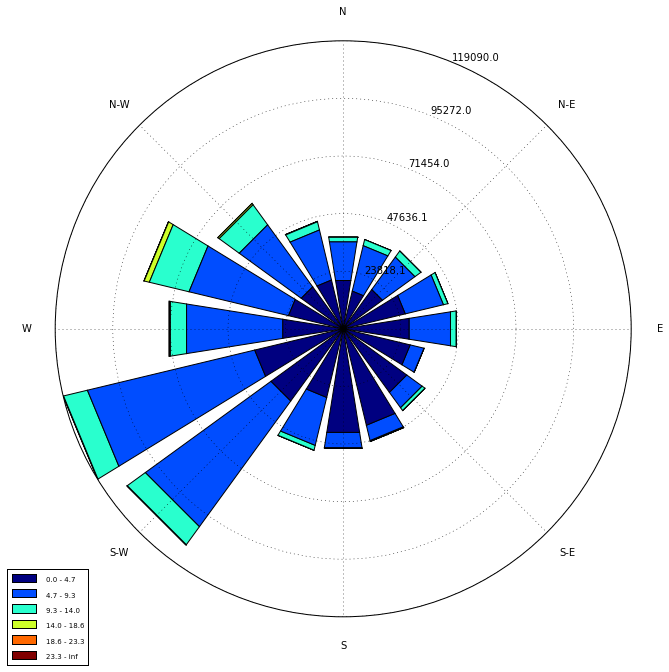

In [16]:
fig, ax = tbx.plotting.windrose(direction=DATA['wdir_vec_mean'], 
                                speed=DATA['wspd_vec_mean'],
                                #bins=[0, 4, 6, 7, 8])
                                )

In [17]:
pw, ph, mbl = (700, 200, 75)
TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select,crosshair"
plotargs = dict(
    tools=TOOLS,
    plot_width=pw,
    plot_height=ph,
    x_axis_type="datetime")

source_1min = ColumnDataSource(data=DATA)
source_1hr = ColumnDataSource(data=DATA.resample('1H', how='mean', loffset=datetime.timedelta(minutes=30)))

#s1 = figure(**plotargs)
#s1.line('index', 'wspd_vec_mean', source=source_1min)
#s1.line('index', 'wspd_vec_mean', source=source_1hr, color='firebrick')
#s1.yaxis.axis_label = 'm/s'

#s2 = figure(tools=TOOLS, plot_width=pw, plot_height=ph, x_range=s1.x_range, x_axis_type = "datetime")
#s2.line('index', 'temp_mean', source=source_1min)
#s2.yaxis.axis_label = 'degrees C'

#s3 = figure(tools=TOOLS, plot_width=pw, plot_height=ph, x_range=s1.x_range, x_axis_type = "datetime")
#s3.line('index', 'atmos_pressure', source=source_1min)
#s3.yaxis.axis_label = 'hPa'

#s4 = figure(x_range=s1.x_range, **plotargs)
s4 = figure(**plotargs)
s4.circle('index', 'CCN01', source=source_1hr, legend='0.1% ss')
s4.circle('index', 'CCN05', color='firebrick', source=source_1hr, legend='0.8% ss')
s4.yaxis.axis_label = 'CCN Number'

s5 = figure(x_range=s4.x_range, **plotargs)
s5.circle('index', 'org_precip_rate_mean', source=source_1min)
s5.yaxis.axis_label = "Precip Rate"

#axes = [s1, s2, s3, s4, s5]
axes = [s4, s5]
for a in axes[:-1]:
    a.xaxis.major_label_text_font_size = '0'
    a.xaxis.major_tick_line_alpha = 0
for a in axes:
    a.min_border_left = mbl

In [18]:
p = gridplot([[a] for a in axes], min_border_bottom=0, min_border_top=0)
show(p)